This work implements a simple class activation map (CAM) of a model trained on the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). This will show what parts of the image the model was paying attention to when deciding the class of the image.

# Package

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

print("tf version: ", tf.__version__)

tf version:  2.10.0


# Data download and process

In [2]:
# set up "download" to True when first time download
splits, info = tfds.load('fashion_mnist', with_info=True, split=['train', 'test'], 
                         data_dir='./MNIST', download=False)

Metal device set to: Apple M2


2022-10-15 22:08:47.664835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-15 22:08:47.665549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
train_data, test_data = splits

In [4]:
image_shape = info.features['image'].shape
train_num_examples = len(train_data)
test_num_examples = len(test_data)

print('image shape: ', str(image_shape))
print('numbers of trainning example: ', train_num_examples)
print('numbers of test example: ', test_num_examples)

image shape:  (28, 28, 1)
numbers of trainning example:  60000
numbers of test example:  10000


In [5]:
# image normalization and formating
def format_image(data):
    image = data['image']
    image = tf.cast(image, tf.float32)
    image = image / 255.
    
    return (image, data['label'])

In [6]:
#display a sample image in the train data
def show_sample_img():
    for sample in train_data.take(1):
        plt.imshow(sample['image'])

2022-10-15 22:10:21.458957: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-15 22:10:21.500274: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


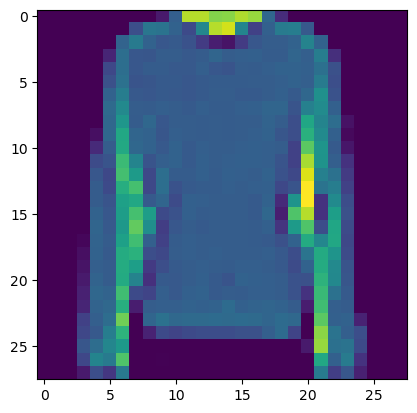

In [7]:
show_sample_img()

In [9]:
# generate the batch dataset 
batch_size = 32
train_dataset = train_data.map(format_image).shuffle(buffer_size=1024).batch(batch_size).prefetch(-1)
test_dataset = test_data.map(format_image).batch(batch_size)

# Define a sample model

In [10]:
def sample_model(inputs):
    
    x = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='SAME')(inputs)
    # pooling layer with a stride of 2 will reduce the image dimensions by half
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # pass through more convolutions with increasing filters
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
    # use global average pooling to take into account lesser intensity pixels
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    
    # output class probabilities
    output = tf.keras.layers.Dense(10, 'softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    
    return model

In [11]:
inputs = tf.keras.layers.Input(image_shape)
model = sample_model(inputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496 

In [12]:
#compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [13]:
# train the model
train_step = train_num_examples // batch_size
validation_step = test_num_examples // batch_size
EPOCHs = 5
model.fit(train_dataset, epochs=EPOCHs, validation_data=test_dataset, steps_per_epoch=train_step)

Epoch 1/5


2022-10-15 22:12:46.049740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1873/1875 [============================>.] - ETA: 0s - loss: 0.5846 - acc: 0.7844

2022-10-15 22:13:01.942701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 17s 9ms/step - loss: 0.5845 - acc: 0.7844 - val_loss: 0.4269 - val_acc: 0.8412
Epoch 2/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.3621 - acc: 0.8673 - val_loss: 0.3516 - val_acc: 0.8716
Epoch 3/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.3078 - acc: 0.8861 - val_loss: 0.3652 - val_acc: 0.8634
Epoch 4/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2728 - acc: 0.8990 - val_loss: 0.2776 - val_acc: 0.9027
Epoch 5/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2468 - acc: 0.9091 - val_loss: 0.2951 - val_acc: 0.8969


## Generate the Class Activation Map

To generate the class activation map, we want to get the features detected in the last convolution layer and see which ones are most active when generating the output probabilities. 

In [14]:
# final convolution layer
print(model.layers[-3].name)

# global average pooling layer
print(model.layers[-2].name)

# output of the classifier
print(model.layers[-1].name)

conv2d_3
global_average_pooling2d
dense


In [15]:
cam_model = tf.keras.Model(inputs=model.input,outputs=[model.layers[-3].output, model.layers[-1].output])
cam_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          1849

In [25]:
# get the features and results of the test images using the newly created model
features, results = cam_model.predict(test_dataset)
X_test = [x['image'] for x in list(test_data)]
# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

313/313 [==============================] - 0s 1ms/step
features shape:  (10000, 3, 3, 128)
results shape (10000, 10)


In [16]:
last_dense_layer = model.layers[-1]
# get the weights list. index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

There are 128 feature weights and 10 classes.


In [17]:
def show_cam(image_index):
    '''displays the class activation map of a particular image'''

    # takes the features of the chosen image
    features_for_img = features[image_index,:,:,:]

    # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

    # get the gap weights at the predicted class
    class_activation_weights = gap_weights[:,prediction]

    # upsample the features to the image's original size (28 x 28)
    class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)

    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)
    
#     print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))
    
    # show the upsampled image
    plt.imshow(np.squeeze(X_test[image_index],-1), alpha=0.5)
    
    # strongly classified (95% probability) images will be in green, else red
    if results[image_index][prediction]>0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Reds'

    # overlay the cam output
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)
    plt.xlabel('Probability: ' + str(results[image_index][prediction]))


In [29]:
def show_maps(desired_class, num_maps, save_img=False):
    '''
    goes through the first 10,000 test images and generates CAMs 
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class < 10:
        print("please choose a class less than 10")

    # go through the first 10000 images
    fig = plt.figure()
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps*num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            ax = fig.add_subplot(num_maps, num_maps, counter)
            show_cam(i)
            ax.set_xticks([])
            ax.set_yticks([])
    if save_img:
        plt.savefig('mnist.jpg', bbox_inches='tight')

## show the CAM, where darker area implies the more intension the model focus on

In [30]:
show_maps(desired_class=7, num_maps=2, save_img=)

SyntaxError: positional argument follows keyword argument (2810926482.py, line 1)